In [101]:
import calendar
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import seaborn as sns

rides = pd.read_csv('./data/rides.csv', parse_dates=['ride_start', 'ride_end'], dtype={'pickup_zip': 'str', 'dropoff_zip': 'str'})
# Exclude non-passenger rides
rides = rides.query('ride_type not in ("Connect Express", "Connect Saver", "Delivery", "Package Express")')
print(rides.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4573 entries, 0 to 4593
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ride_type        4573 non-null   object        
 1   ride_category    4573 non-null   object        
 2   status           4573 non-null   object        
 3   tip              4573 non-null   float64       
 4   surge            4573 non-null   float64       
 5   duration         4573 non-null   int64         
 6   distance         4573 non-null   float64       
 7   pickup_address   4573 non-null   object        
 8   dropoff_address  4573 non-null   object        
 9   pickup_zip       4573 non-null   object        
 10  dropoff_zip      4572 non-null   object        
 11  earnings         4573 non-null   float64       
 12  base_pay         4573 non-null   float64       
 13  ride_start       4573 non-null   datetime64[ns]
 14  ride_end         4573 non-null   datetime64[n

## 4️⃣3️⃣0️⃣0️⃣ 
I worked as an Uber driver in Chicago between January 2023 and September 2024, during which I completed almost 4300 passenger rides.

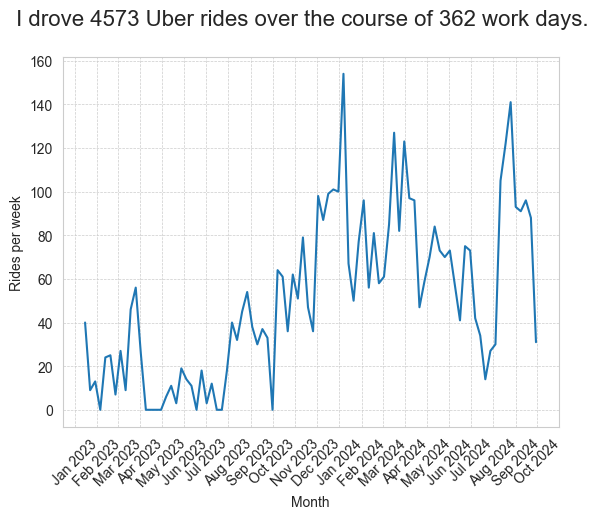

<Figure size 640x480 with 0 Axes>

In [102]:
# Show a chart of ride counts per day betwen Jan 2023 and Sep 2024
#daily_counts = rides.resample('D', on='ride_start').size().reset_index(name='ride_count')
weekly_counts = rides.resample('W', on='ride_start').size().reset_index(name='ride_count')

# Plot the daily ride counts as a line chart
sns.lineplot(data=weekly_counts, x='ride_start', y='ride_count')

# Set x-axis ticks to show only months
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

ride_count = rides['ride_start'].count()
work_days = rides['ride_start'].dt.date.nunique()
plt.suptitle(f"I drove {ride_count} Uber rides over the course of {work_days} work days.", size=16)
plt.xlabel('Month')
plt.ylabel('Rides per week')
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()
plt.savefig(f"visualizations/Ride_Count_per_Week.png", dpi=300)

## 🚙🚐🐶🤹🏻‍♂️ 
I did a variety of Uber ride types including UberX, UberX Share, UberXL, Comfort, Business Comfort, Uber Pet, and UberX Priority.

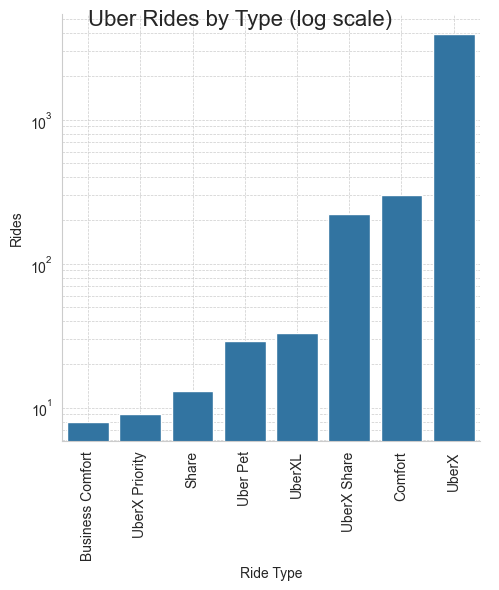

<Figure size 640x480 with 0 Axes>

In [103]:
# Show the distribution of number of rides per ride type
type_counts = rides.groupby('ride_type').size().reset_index(name='ride_count').sort_values(by='ride_count')
sns.catplot(data=type_counts, x='ride_type', y='ride_count', kind='bar')
plt.suptitle("Uber Rides by Type (log scale)", size=16)
plt.yscale('log')
plt.xlabel('Ride Type')
plt.ylabel('Rides')
plt.xticks(rotation=90)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()
plt.savefig(f"visualizations/Uber_Rides_by_Type.png", dpi=300)

## 🌇🏙️🌆🌃 
I drove at almost all hours of the day and night and I worked 7 days a week.

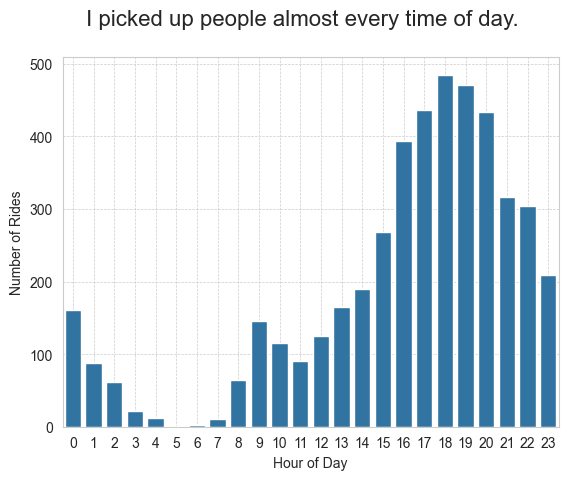

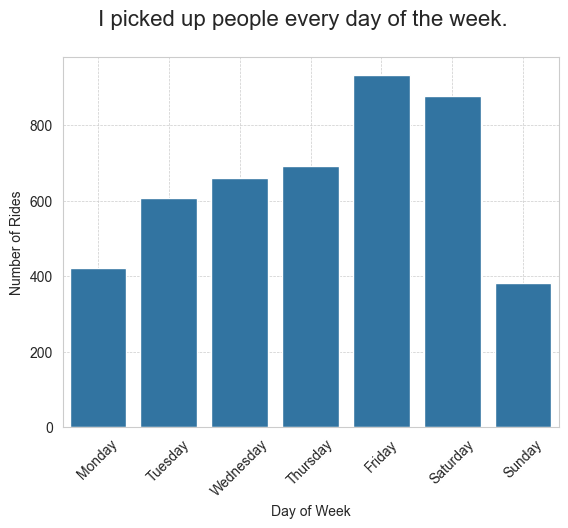

<Figure size 640x480 with 0 Axes>

In [104]:
# Show the distribution across the hours of a day and days of the week for how many rides I did at each time/day
rides['hour'] = rides['ride_start'].dt.hour
hour_counts = rides.groupby('hour').size().reset_index(name='ride_count')

sns.barplot(x='hour', y='ride_count', data=hour_counts, order=range(24))
plt.suptitle("I picked up people almost every time of day.", size=16)
plt.xlabel('Hour of Day')
plt.ylabel('Number of Rides')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()
plt.savefig(f"visualizations/Ride_Count_by_Hour.png", dpi=300)

rides['day_of_week'] = rides['ride_start'].dt.day_of_week
day_counts = rides.groupby('day_of_week').size().reset_index(name='ride_count')
day_counts['day_of_week'] = day_counts['day_of_week'].map(lambda x: calendar.day_name[x])

order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.barplot(x='day_of_week', y='ride_count', data=day_counts, order=order)
plt.suptitle("I picked up people every day of the week.", size=16)
plt.xlabel('Day of Week')
plt.ylabel('Number of Rides')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)
plt.show()
plt.savefig(f"visualizations/Ride_Count_by_Day_of_Week.png", dpi=300)


## 🥳🪅🎸🌭 
I drove during the busiest festivals and city events, downtown along with almost all other neighborhoods of Chicago.

In [105]:
# Show the range of ZIP codes I picked up or dropped off in on a map of Chicago
rides_by_pickup_zip = rides \
                        .groupby(['pickup_zip'])['ride_start'] \
                        .count() \
                        .reset_index(name='ride_count') \
                        .rename(columns={'pickup_zip': 'zip'})
rides_by_dropoff_zip = rides \
                        .groupby(['dropoff_zip'])['ride_start'] \
                        .count() \
                        .reset_index(name='ride_count') \
                        .rename(columns={'dropoff_zip': 'zip'})
combined = pd.concat([rides_by_pickup_zip, rides_by_dropoff_zip])
total_rides_by_zip = combined.groupby('zip', as_index=False)['ride_count'].sum()
zipcodes = pd.read_csv('data/zip_code_to_lat_long.csv', dtype={'zip': 'str'})
total_rides_by_zip = total_rides_by_zip \
                        .merge(zipcodes, on='zip', how='left')[['zip', 'ride_count', 'latitude', 'longitude']] \
                        .dropna(subset=['latitude', 'longitude'])
print(total_rides_by_zip)

chicago_map = folium.Map(location=[41.8781, -87.6298], zoom_start=10)
heat_data = [[row['latitude'], row['longitude'], row['ride_count']] for index, row in total_rides_by_zip.iterrows()]
HeatMap(heat_data, radius=15, max_opacity=0.8).add_to(chicago_map)

# Add markers for each zipcode with tooltip and popup labels
for index, row in total_rides_by_zip.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Zip: {row['zip']}<br>Count: {row['ride_count']}",
        tooltip=row['zip'],
        icon=folium.DivIcon(html=f"""<div style="font-family: courier new; color: blue">{row['zip']}</div>""")
    ).add_to(chicago_map)

chicago_map.save('chicago_map.html')

# Show the intersection between the rides I drove and the calendar of Chicago events
events = pd.read_csv('data/chicago_events.csv')


       zip  ride_count   latitude  longitude
1    46394           1  41.678891 -87.500609
2    60004           1  42.111995 -87.979921
3    60005           1  42.065588 -87.983624
4    60007           1  42.005441 -88.013215
5    60008           1  42.072481 -88.022440
..     ...         ...        ...        ...
141  60714          14  42.033787 -87.819500
142  60803           6  41.673159 -87.726135
143  60804          12  41.845914 -87.762193
144  60805           7  41.720134 -87.702920
145  60827           1  41.650162 -87.630667

[143 rows x 4 columns]


## ☀️⛈️🌪️❄️
I drove in every kind of weather, from the coldest deep freeze in Chicago to the days above 100 F, from droughts to torrential rainstorms to blinding blizzards. 

In [106]:
# Show temperature ranges for the days I drove


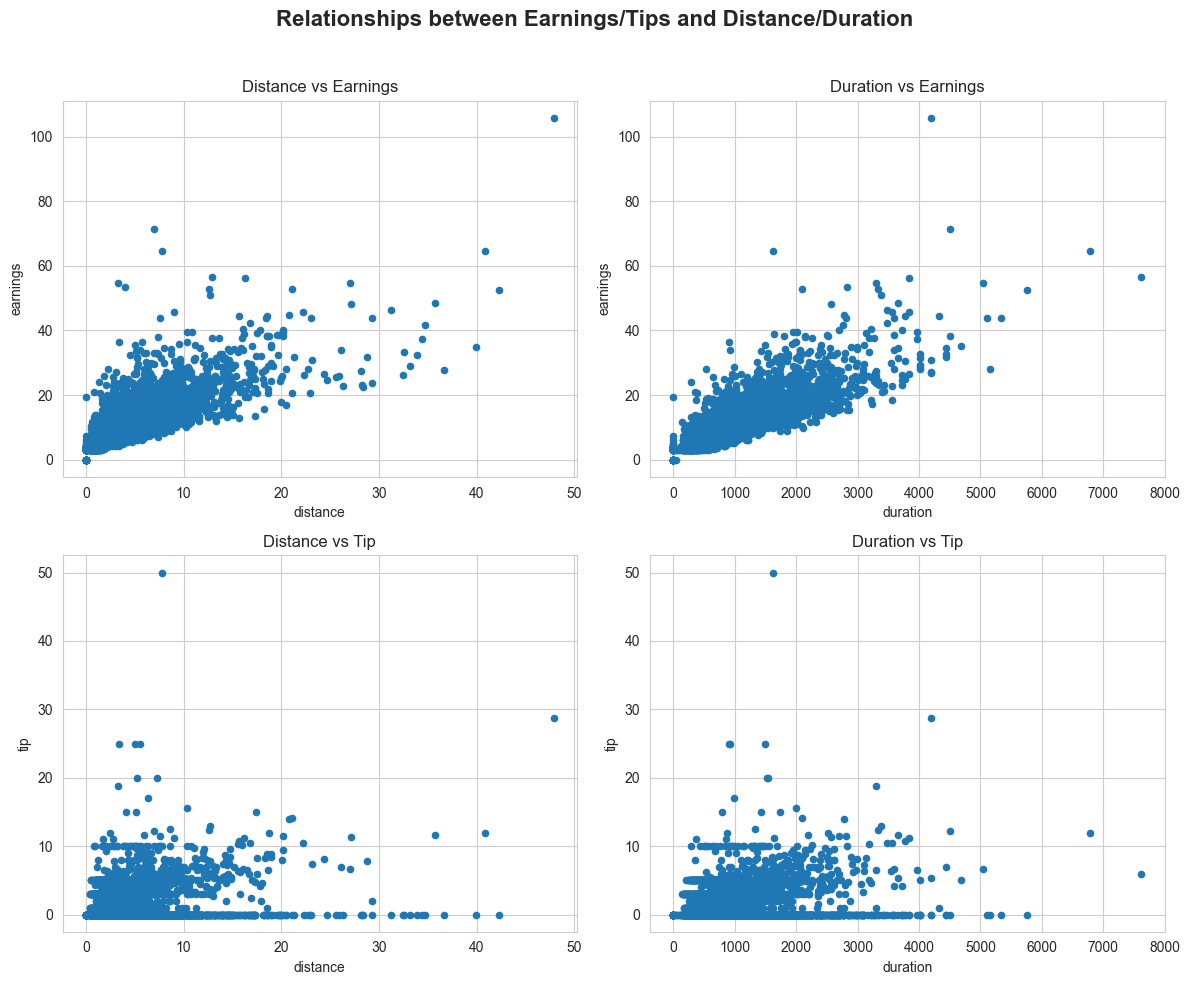

In [107]:
# Let's look at some scatter plots to reveal the relationship between earnings/tips and distance/time
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Relationships between Earnings/Tips and Distance/Duration', fontsize=16, fontweight="bold")

# Define the pairs of variables to plot
plot_pairs = [('distance', 'earnings'), ('duration', 'earnings'), ('distance', 'tip'), ('duration', 'tip')]

# Flatten the axes array for easy iteration
axes = axes.flatten()

for ax, (x, y) in zip(axes, plot_pairs):
    rides.plot.scatter(x=x, y=y, ax=ax)
    ax.set_title(f'{x.capitalize()} vs {y.capitalize()}')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f"visualizations/Earnings_Tips_vs_Distance_Duration.png", dpi=300)
plt.show()

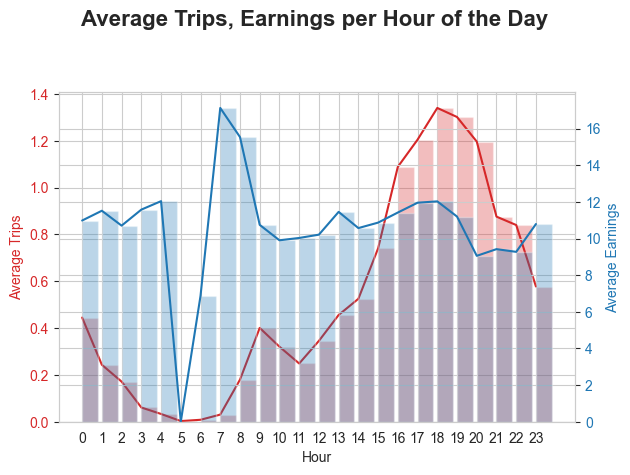

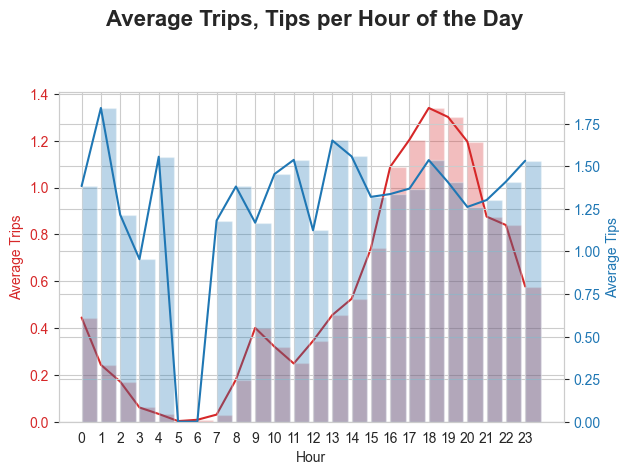

In [108]:
avg_earnings_per_hour = rides.groupby('hour')['earnings'].mean().to_frame()
avg_tips_per_hour = rides.groupby('hour')['tip'].mean().to_frame()
avg_trips_per_hour = rides.groupby('hour')['ride_start'].nunique().to_frame().rename(columns={'ride_start': 'trips'})
avg_trips_per_hour['trips'] = avg_trips_per_hour['trips'] / unique_days

# Make sure all hours are represented, not just the ones in the data. I know I wasn't up for driving very early shifts.
all_hours = pd.DataFrame({'hour': range(24)})
avg_earnings_per_hour = pd.merge(all_hours, avg_earnings_per_hour, left_index=True, right_index=True, how='left')
avg_earnings_per_hour.fillna({'earnings': 0}, inplace=True)
avg_tips_per_hour = pd.merge(all_hours, avg_tips_per_hour, left_index=True, right_index=True, how='left')
avg_tips_per_hour.fillna({'tips': 0}, inplace=True)
avg_trips_per_hour = pd.merge(all_hours, avg_trips_per_hour, left_index=True, right_index=True, how='left')
avg_trips_per_hour.fillna({'trips': 0}, inplace=True)

for (df, field, title, color) in [(avg_earnings_per_hour, 'earnings', 'Earnings', 'tab:blue'),
                                  (avg_tips_per_hour, 'tip', 'Tips', 'tab:blue')]:
    fig, ax1 = plt.subplots()

    fig.suptitle(f"Average Trips, {title} per Hour of the Day", fontsize=16, fontweight="bold")

    # Plot average trips per hour on the left y-axis using translucent bars and a line
    ax1.set_xlabel('Hour')
    ax1.set_ylabel('Average Trips', color='tab:red')
    ax1.bar(avg_trips_per_hour['hour'], avg_trips_per_hour['trips'], color='tab:red', alpha=0.3, align='edge')
    ax1.plot(avg_trips_per_hour['hour'], avg_trips_per_hour['trips'], color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Create a second y-axis for average earnings per hour with translucent bars and a line
    ax2 = ax1.twinx()
    ax2.set_ylabel(f"Average {title}", color=color)
    ax2.bar(df['hour'], df[field], color=color, alpha=0.3, align='edge')
    ax2.plot(df['hour'], df[field], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Set xticks for every hour (0 through 23)
    ax1.set_xticks(range(24))

    fig.tight_layout(rect=[0, 0, 1, 0.92])
    plt.savefig(f"visualizations/AvgTrips_vs_{title}_per_hour.png", dpi=300)
    plt.show()

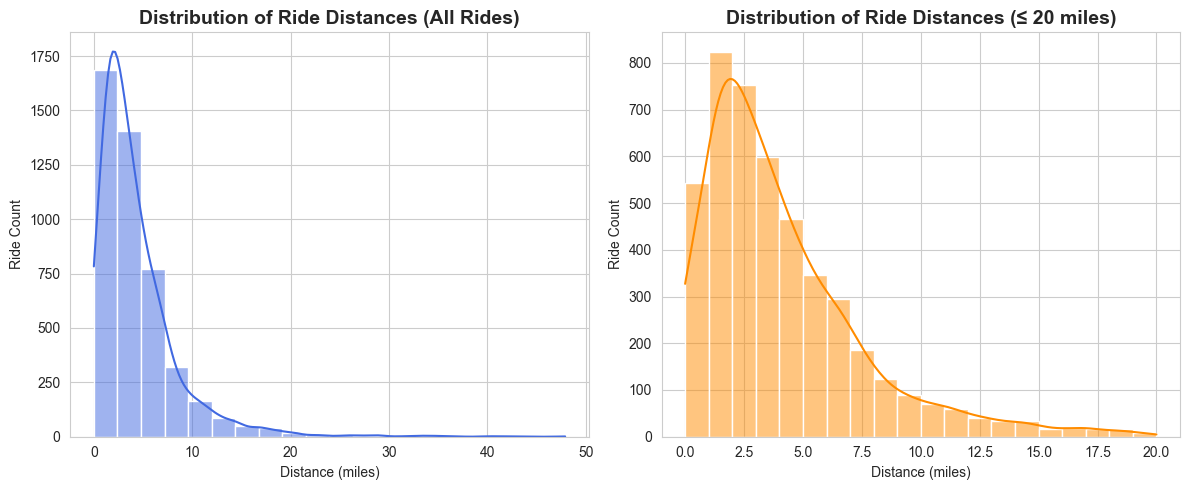

In [109]:
sns.set_style("whitegrid")

# Create a larger figure for better visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Full distance histogram
sns.histplot(rides['distance'], bins=20, kde=True, ax=axes[0], color="royalblue")
axes[0].set_title("Distribution of Ride Distances (All Rides)", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Distance (miles)")
axes[0].set_ylabel("Ride Count")

# Histogram for rides <= 20 miles
sns.histplot(rides.query('distance <= 20')['distance'], bins=20, kde=True, ax=axes[1], color="darkorange")
axes[1].set_title("Distribution of Ride Distances (≤ 20 miles)", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Distance (miles)")
axes[1].set_ylabel("Ride Count")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [110]:
grouped = rides.groupby('ride_type').agg({
    'ride_start': 'count',
    'base_pay': 'sum',
    'surge': 'sum',
    'tip': 'sum',
    'earnings': 'sum'
}).reset_index()
grouped = grouped.rename(columns={'ride_start': 'ride_count'})
print(grouped.sort_values(by=['ride_type']).to_string(index=False))

grouped['surge/base_pay'] = round(grouped['surge'] / grouped['base_pay'], 3)
grouped['tip/base_pay'] = round(grouped['tip'] / grouped['base_pay'], 3)
grouped['surge/earnings'] = round(grouped['surge'] / grouped['earnings'], 3)
grouped['tip/earnings'] = round(grouped['tip'] / grouped['earnings'], 3)
grouped['earnings/base_pay'] = round(grouped['earnings'] / grouped['base_pay'], 3)

print("\nRide Types sorted by Surge/Earnings Ratio:\n")
print(grouped[['ride_type', 'ride_count', 'surge/earnings']].sort_values(by=['surge/earnings'], ascending=False).to_string(index=False))
print("\nRide Types sorted by Tip/Base Pay Ratio:\n")
print(grouped[['ride_type', 'ride_count', 'tip/base_pay']].sort_values(by=['tip/base_pay'], ascending=False).to_string(index=False))
print("\nRide Types sorted by Tip/Earnings Ratio:\n")
print(grouped[['ride_type', 'ride_count', 'tip/earnings']].sort_values(by=['tip/earnings'], ascending=False).to_string(index=False))
print("\nRide Types sorted by Earnings/Base Pay Ratio:\n")
print(grouped[['ride_type', 'ride_count', 'earnings/base_pay']].sort_values(by=['earnings/base_pay'], ascending=False).to_string(index=False))

       ride_type  ride_count  base_pay   surge     tip  earnings
Business Comfort           8    102.10    6.75   26.31    135.16
         Comfort         301   3831.24  347.50  869.20   5047.94
           Share          13    189.08    6.25    6.00    201.33
        Uber Pet          29    341.55    8.75   31.05    381.35
           UberX        3958  32639.23 2406.00 5117.10  40162.33
  UberX Priority           9    115.22   14.00   30.20    159.42
     UberX Share         222   2544.32  228.75  213.88   2986.95
          UberXL          33    374.83   17.25   88.94    481.02

Ride Types sorted by Surge/Earnings Ratio:

       ride_type  ride_count  surge/earnings
  UberX Priority           9           0.088
     UberX Share         222           0.077
         Comfort         301           0.069
           UberX        3958           0.060
Business Comfort           8           0.050
          UberXL          33           0.036
           Share          13           0.031
        Ub